## Forecasting using transformations
***
Some common transformations which can be used when modelling were discussed in Section 3.1. When forecasting from a model with transformations, we first produce forecasts of the transformed data. Then, we need to reverse the transformation (or back-transform) to obtain forecasts on the original scale. For Box-Cox transformations given by, the reverse transformation is given by

$$
y_{t}=
\begin{cases}
exp(w_{t}) & \quad \text{if $λ=0;$}\\ 
sign(λw_{t}+1)|λw_{t}+1|^{1/λ} & \quad \text{otherwise;}
\end{cases}
$$

## Prediction intervals with transformations

If a transformation has been used, then the prediction interval is first computed on the transformed scale, and the end points are back-transformed to give a prediction interval on the original scale. This approach preserves the probability coverage of the prediction interval, although it will no longer be symmetric around the point forecast.

Transformations sometimes make little difference to the point forecasts but have a large effect on prediction intervals.

## Bias adjustments

One issue with using mathematical transformations such as Box-Cox transformations is that the back-transformed point forecast will not be the mean of the forecast distribution. In fact, it will usually be the median of the forecast distribution (assuming that the distribution on the transformed space is symmetric). For many purposes, this is acceptable, although the mean is usually preferable. For example, you may wish to add up sales forecasts from various regions to form a forecast for the whole country. But medians do not add up, whereas means do.

For a Box-Cox transformation, the back-transformed mean is given (approximately) by

$$
\hat{y}_{T+h|T}=
\begin{cases}
exp(\hat{w}_{T+h|T}) [1 + \frac{σ_{h}^{2}}{2}] & \quad \text{if $λ=0;$}\\ 
sign(λ\hat{w}_{T+h|T}+1)^{1/λ} [1 + \frac{σ_{h}^{2} (1-λ)}{2(λ\hat{w}_{T+h|T}+1)^{2}}]  & \quad \text{otherwise;}
\end{cases}
$$

where $\hat{w}_{T+h|T}$ is the $h$-step forecast mean and $σ_{h}^{2}$ is the $h$-step forecast variance on the transformed scale. The larger the forecast variance, the bigger the difference between the mean and the median.

The difference between the simple back-transformed forecast given by (5.2) and the mean given by (5.3) is called the **bias**. When we use the mean, rather than the median, we say the point forecasts have been **bias-adjusted**.

To see how much difference this bias-adjustment makes, consider the following example, where we forecast the average annual price of eggs using the drift method with a log transformation $(λ=0)$. The log transformation is useful in this case to ensure the forecasts and the prediction intervals stay positive.

In [1]:
# Import the libraries that we are going to use for the analysis:
import pandas as pd
import numpy as np
import scipy

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.models import RandomWalkWithDrift

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

In [9]:
# Create a dataframe from a csv file:
df_eggs = pd.read_csv("Assets/egg_prices.csv", sep=";")

# Rename columns:
df_eggs.columns = ["ds", "egg_prices"]

# Create a new column in the dataframe, unique_id:
df_eggs["unique_id"] = "egg_prices"

# Return a serie with a log transformation (λ=0):
df_eggs["egg_prices"] = scipy.stats.boxcox(
    df_eggs["egg_prices"].values, lmbda=0, alpha=None, optimizer=None
)

df_eggs.head()

,ds,egg_prices,unique_id
0,1900,5.623259,egg_prices
1,1901,5.753905,egg_prices
2,1902,5.752160,egg_prices
3,1903,5.772220,egg_prices
4,1904,5.751111,egg_prices


In [11]:
# Define the models:
models = [AutoARIMA(season_length=1, approximation=True), RandomWalkWithDrift()]

In [24]:
# Fit and predict:
fcst = StatsForecast(
    models=models,
    # freq="Y",
    freq=1,
    n_jobs=-1,
).fit(df=df_eggs, time_col="ds", target_col="egg_prices")

In [25]:
# We can define the level of the forecast intervals we want to produce. StatsForecast will produce these levels:
levels = [80]

In [26]:
# The forecast function converts the forecast distributions into intervals:
forecasts = fcst.forecast(h=50, level=levels, df=df_eggs, target_col="egg_prices")

In [20]:
# Calculate the exponential of the values forecasted and the intervals:
forecasts["AutoARIMA"] = np.exp(forecasts["AutoARIMA"])
forecasts["AutoARIMA-lo-80"] = np.exp(forecasts["AutoARIMA-lo-80"])
forecasts["AutoARIMA-hi-80"] = np.exp(forecasts["AutoARIMA-hi-80"])
forecasts["RWD"] = np.exp(forecasts["RWD"])

forecasts.head(5)

,unique_id,ds,AutoARIMA,AutoARIMA-lo-80,AutoARIMA-hi-80,RWD,RWD-lo-80,RWD-hi-80
0,egg_prices,1994,62.757076,53.099451,74.171211,61.279118,3.944767,4.286111
1,egg_prices,1995,62.432832,50.607427,77.021471,60.304003,3.856751,4.342046
2,egg_prices,1996,61.705762,48.748199,78.107522,59.344406,3.784616,4.382099
3,egg_prices,1997,60.786768,47.111249,78.432035,58.400078,3.720568,4.414066
4,egg_prices,1998,59.782272,45.595613,78.382981,57.470776,3.661606,4.440947


In [21]:
# Recreate the dataframe with the original values:
df_eggs = pd.read_csv("Assets/egg_prices.csv", sep=";")
df_eggs.columns = ["ds", "egg_prices"]
df_eggs["unique_id"] = "egg_prices"

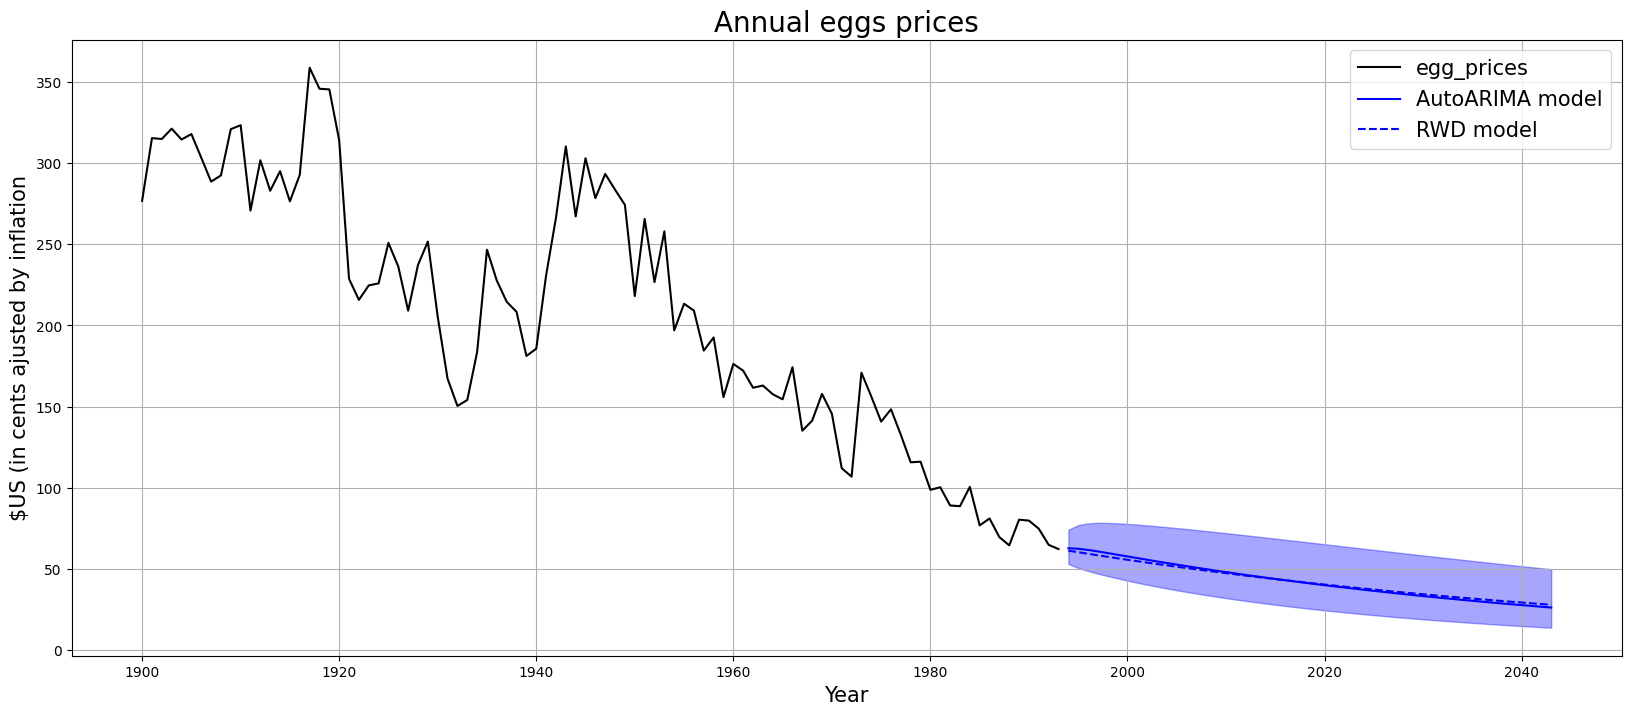

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))

# Concatenate the dataframe of predicted values with the dataframe of observed values:
df_plot = pd.concat([df_eggs, forecasts]).set_index("ds")
plt.plot(df_plot["egg_prices"], "k-", df_plot["AutoARIMA"], "b-", df_plot["RWD"], "b--")

# Specify graph features:
ax.fill_between(
    df_plot.index,
    df_plot["AutoARIMA-lo-80"],
    df_plot["AutoARIMA-hi-80"],
    alpha=0.35,
    color="blue",
    label="auto_arima_level_80",
)
ax.set_title("Annual eggs prices", fontsize=20)
ax.set_ylabel("$US (in cents ajusted by inflation", fontsize=15)
ax.set_xlabel("Year", fontsize=15)
ax.legend(["egg_prices", "AutoARIMA model", "RWD model"], prop={"size": 15})
ax.grid()

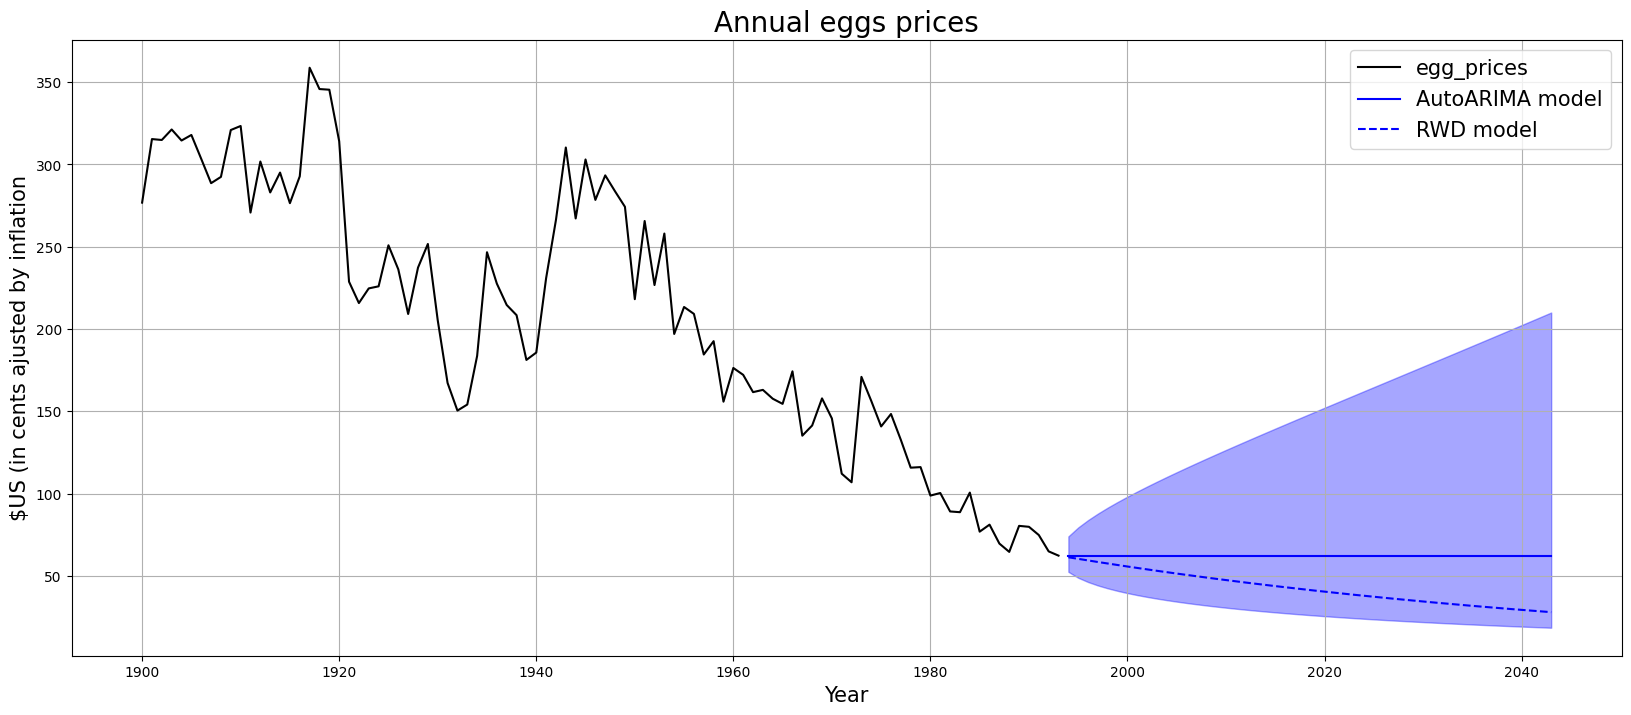

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))

# Concatenate the dataframe of predicted values with the dataframe of observed values:
df_plot = pd.concat([df_eggs, forecasts]).set_index("ds")
plt.plot(df_plot["egg_prices"], "k-", df_plot["AutoARIMA"], "b-", df_plot["RWD"], "b--")

# Specify graph features:
ax.fill_between(
    df_plot.index,
    df_plot["AutoARIMA-lo-80"],
    df_plot["AutoARIMA-hi-80"],
    alpha=0.35,
    color="blue",
    label="auto_arima_level_80",
)
ax.set_title("Annual eggs prices", fontsize=20)
ax.set_ylabel("$US (in cents ajusted by inflation", fontsize=15)
ax.set_xlabel("Year", fontsize=15)
ax.legend(["egg_prices", "AutoARIMA model", "RWD model"], prop={"size": 15})
ax.grid()

<p style="text-align: center;">
The dashed line in Figure 17 shows the RWD forecast while the solid line shows the Auto ARIMA forecast. Notice how the skewed forecast distribution pulls up the Auto ARIMA forecast distribution’s; this is a result of the added term from the **bias adjustment**.
</p>